In [106]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [150]:
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0
    
    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [151]:
def preprocessing(station_name):
    df = pd.read_csv('../Artificial_data/DOGEx_v1/csv/' + station_name + '.csv', header=None)

    df.columns = ['date', 'un', 'ue', 'uz', 'sn', 'se', 'sz']
    df.set_index('date', inplace=True)
    df.drop(['sn', 'se', 'sz'], axis=1, inplace=True)
    df = df['uz']

    offset = 10
    interval_size = 40
    ranges = np.empty((1 * (df.shape[0]-interval_size)//offset, interval_size))

    j=0
    for col in ['uz']:
        i = 0
        while i < ranges.shape[0] / 1:
            ranges[j] = df.iloc[i * offset:i * offset + interval_size]
            i = i + 1   
            j = j + 1

    labels = np.zeros(529, dtype=int)

    idxs = [2, 3, 4, 31, 32, 33, 34, 225, 226, 227, 228, 273, 274, 275, 276]
    for idx in idxs:
        labels[idx] = 1

    data = pd.concat([pd.DataFrame(ranges), pd.DataFrame(labels, columns=['label'])], axis=1)

    regular = data[data.label == 0]
    offsets  = data[data.label == 1]

    offsets_upsampled = resample(offsets, replace=True, n_samples=len(regular), random_state=42)
    data_upsampled = pd.concat([regular, offsets_upsampled])

    X = np.array(data_upsampled.drop('label', axis=1))
    y = np.array(data_upsampled['label'])

    return X, y

In [153]:
X, y = preprocessing('awmi')

In [155]:
X.shape

(1028, 40)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
# Shortening classes due to massive runtime with whole dataset
X_train = X_train[0:50, :]
y_train = y_train[0:50]

In [27]:
X_test = X_test[0:25, :]
y_test = y_test[0:25]

In [28]:
#parameters = {'n_neighbors':[2, 4, 8]}
clf = KNeighborsClassifier(metric =DTW)
clf.fit(X_train, y_train)

KNeighborsClassifier(metric=<function DTW at 0x147cc34c0>)

In [29]:
y_pred = clf.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.86      1.00      0.92        12

    accuracy                           0.92        25
   macro avg       0.93      0.92      0.92        25
weighted avg       0.93      0.92      0.92        25



In [69]:
#test with second dataset
test = pd.read_csv('../Artificial_data/DOGEx_v1/csv/zesj.csv', header=None)
test.columns = ['date', 'un', 'ue', 'uz', 'sn', 'se', 'sz']
test.set_index('date', inplace=True)
test.drop(['sn', 'se', 'sz'], axis=1, inplace=True)

test = test['uz']

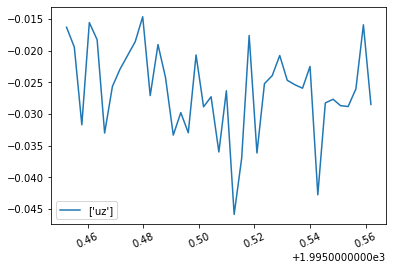

In [90]:
plt.plot(test.iloc[800:840], label=['uz']);
plt.xticks(rotation=25)
plt.legend();

In [93]:
# Why always predicting 1?
clf.predict(np.array(test.iloc[1020:1060]).reshape(1, -1))

array([1])